# Partial-UCB Optimization Example

This notebook demonstrates a simple example of maximizing a composite function $f(x) = f_2(f_1(x))$ using the Partial-UCB algorithm.

The process includes:
1. Defining the true underlying functions $f_1$ and $f_2$.
2. Visualizing the shapes of these true functions and the composite objective function.
3. Setting up the optimization problem, treating $f_1$ and $f_2$ as black-box functions with associated query costs.
4. Initializing and running the Partial-UCB algorithm.
5. Visualizing the optimization progress, including objective values, estimated values, costs, and acquisition function values over iterations.
6. Displaying the trajectory of queried points in the input space.

In [1]:
import sys
sys.path.append("..")

In [2]:
import networkx as nx
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pucb
import pucb.query_algorithm
import pucb.util
from pucb.problem import Problem, Function, FunctionNetwork, ObjectiveSense

torch.manual_seed(0);

/mnt/d/repos/partial_ucb/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the Actual Objective Function

As an example, we define the actual functions $f_1$ and $f_2$. $f_1$ is a function from a two-dimensional input to a one-dimensional output, and $f_2$ is a one-dimensional function that takes the output of $f_1$ as input.

The functions are defined as:
$$
\begin{align*}
f_1(x_1, x_2) & = \sin(x_1) \cos(x_2) & (x_1, x_2 \in [-2, 2])\\
f_2(y) & = y^2 + 0.5y
\end{align*}
$$

The composite objective function is $f(x_1, x_2) = f_2(f_1(x_1, x_2))$.

In [3]:
def true_f1(x):
    return (torch.sin(x[:, 0]) * torch.cos(x[:, 1])).reshape(-1, 1)

def true_f2(x):
    return (x**2 + 0.5*x).reshape(-1, 1)

def true_obj(x):
    return true_f2(true_f1(x))

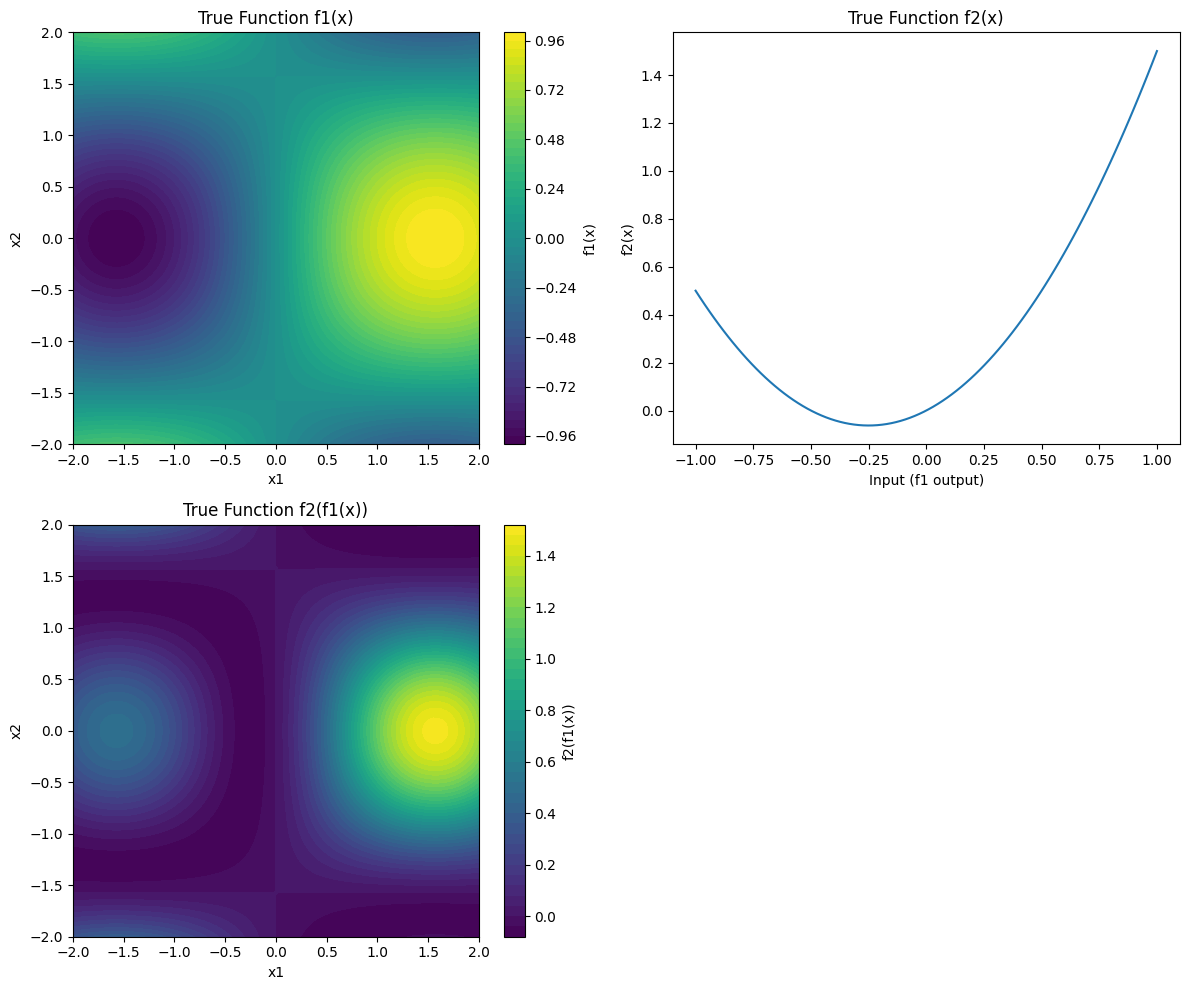

In [4]:
# Visualize the function graphs (to check the shape of the true functions)
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.flatten(), Y.flatten()))
Z1 = true_f1(torch.tensor(points, dtype=torch.double)).numpy().reshape(X.shape)
f1_samples = true_f1(torch.tensor(points[:10], dtype=torch.double)).numpy()
f2_samples = true_f2(torch.tensor(f1_samples, dtype=torch.double)).numpy()

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.contourf(X, Y, Z1, 50, cmap='viridis')
plt.colorbar(label='f1(x)')
plt.title('True Function f1(x)')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(222)
x_f2 = np.linspace(-1, 1, 100)
y_f2 = true_f2(torch.tensor(x_f2.reshape(-1, 1), dtype=torch.double)).numpy()
plt.plot(x_f2, y_f2)
plt.title('True Function f2(x)')
plt.xlabel('Input (f1 output)')
plt.ylabel('f2(x)')

plt.subplot(223)
Z2 = true_obj(torch.tensor(points, dtype=torch.double)).numpy().reshape(X.shape)
plt.contourf(X, Y, Z2, 50, cmap='viridis')
plt.colorbar(label='f2(f1(x))')
plt.title('True Function f2(f1(x))')
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()

# Optimization using Partial-UCB

Use the Partial-UCB algorithm to search for the maximum value of this function.

In [5]:
# Cost of evaluating the functions
f1_eval_cost = 1
f2_eval_cost = 49


num_initial_samples = 3  # number of initial samples
budget = 300  # total budget for evaluations
max_iter = 20  # maximum number of iterations

In [6]:
# Set the actual objective function
funcs = {
    "f1": Function(
        func=None,
        is_known=False,  # Treated as unknown function
        in_ndim=2,
        out_ndim=1,
        cost=f1_eval_cost
    ),
    "f2": Function(
        func=None,
        is_known=False,  # Treated as unknown function
        in_ndim=1,
        out_ndim=1,
        cost=f2_eval_cost
    )
}

dag = nx.DiGraph()
dag.add_node("f1", func="f1", raw_input=[(i, i) for i in range(2)])
dag.add_node("f2", func="f2")
dag.add_edge("f1", "f2", index=[(0, 0)])

bounds = torch.tensor(
    [[-2.0 for _ in range(2)], [2.0 for _ in range(2)]], dtype=torch.double
)

# Problem setting using actual functions
prob = Problem(
    obj=FunctionNetwork(functions=funcs, dag=dag),
    sense=ObjectiveSense.MAXIMIZE,
    bounds=bounds,
)

In [7]:
# Initialize the partial-ucb algorithm
method = pucb.query_algorithm.PartialUCB(
    problem=prob,  # Problem setting including unknown functions
    alpha=2.0,     # UCB exploration parameter
    warm_start_model=True,
    train_yvar=1e-5,
)

In [8]:
# Generate and evaluate initial samples
initial_samples = pucb.util.uniform_sampling(num_initial_samples, prob.bounds)

# Prepare data
f1_res = true_f1(initial_samples)
f2_res = true_f2(f1_res)
data = {
    "f1": (initial_samples, f1_res),
    "f2": (f1_res, f2_res),
}

# Get initial solution
initial_sol, initial_est_val = method.get_solution(data)
initial_real_val = true_obj(initial_sol).item()
print(f"Initial solution: {initial_sol.tolist()}")
print(f"Initial estimated objective: {initial_est_val}")
print(f"Initial true objective: {initial_real_val}")

Initial solution: [[-0.7849253039082953, 0.5572629675001369]]
Initial estimated objective: 0.05883964387509421
Initial true objective: 0.059889278716114436


In [9]:
# Optimization loop
results = {
    "objective_values": [initial_real_val],
    "estimated_values": [initial_est_val],
    "acquisition_values": [float('nan')],
    "costs": [0],
    "inputs": [initial_sol.tolist()[0]],
}

for i in tqdm(range(max_iter)):
    # Get query
    query = method.step(data, budget)
    
    if query is None:
        print(f"No query returned with remaining budget: {budget}")
        break
    
    # Execute query
    if query.function_name == "f1":
        res = true_f1(query.input)
    elif query.function_name == "f2":
        res = true_f2(query.input)
    data_input = data[query.function_name][0]
    data_output = data[query.function_name][1]
    data[query.function_name] = (
        torch.cat((data_input, query.input), dim=0),
        torch.cat((data_output, res), dim=0),
    )
    tmp_cost = prob.obj.get_cost(query.function_name)
    budget -= tmp_cost
    
    acquisition_value = query.info.get("acquisition_value", float('nan'))
    results["acquisition_values"].append(acquisition_value)
    
    # Get new solution
    new_sol, new_est = method.get_solution(data)
    real_val = true_obj(new_sol).item()
    
    # Save results
    results["objective_values"].append(real_val)
    results["estimated_values"].append(new_est)
    results["costs"].append(tmp_cost)
    results["inputs"].append(new_sol.tolist()[0])
    
    # Terminate if budget is exhausted.
    if budget <= 0:
        print("Budget exhausted.")
        break

# print("\nOptimization complete.")
print(f"Final solution found: {new_sol.tolist()[0]}")
print(f"Final solution's objective value: {real_val}")

100%|██████████| 20/20 [00:40<00:00,  2.00s/it]

Final solution found: [1.5718661651578738, 0.004422962495818846]
Final solution's objective value: 1.4999741162219877


# Visualize Results

Display the optimization progress as a graph.

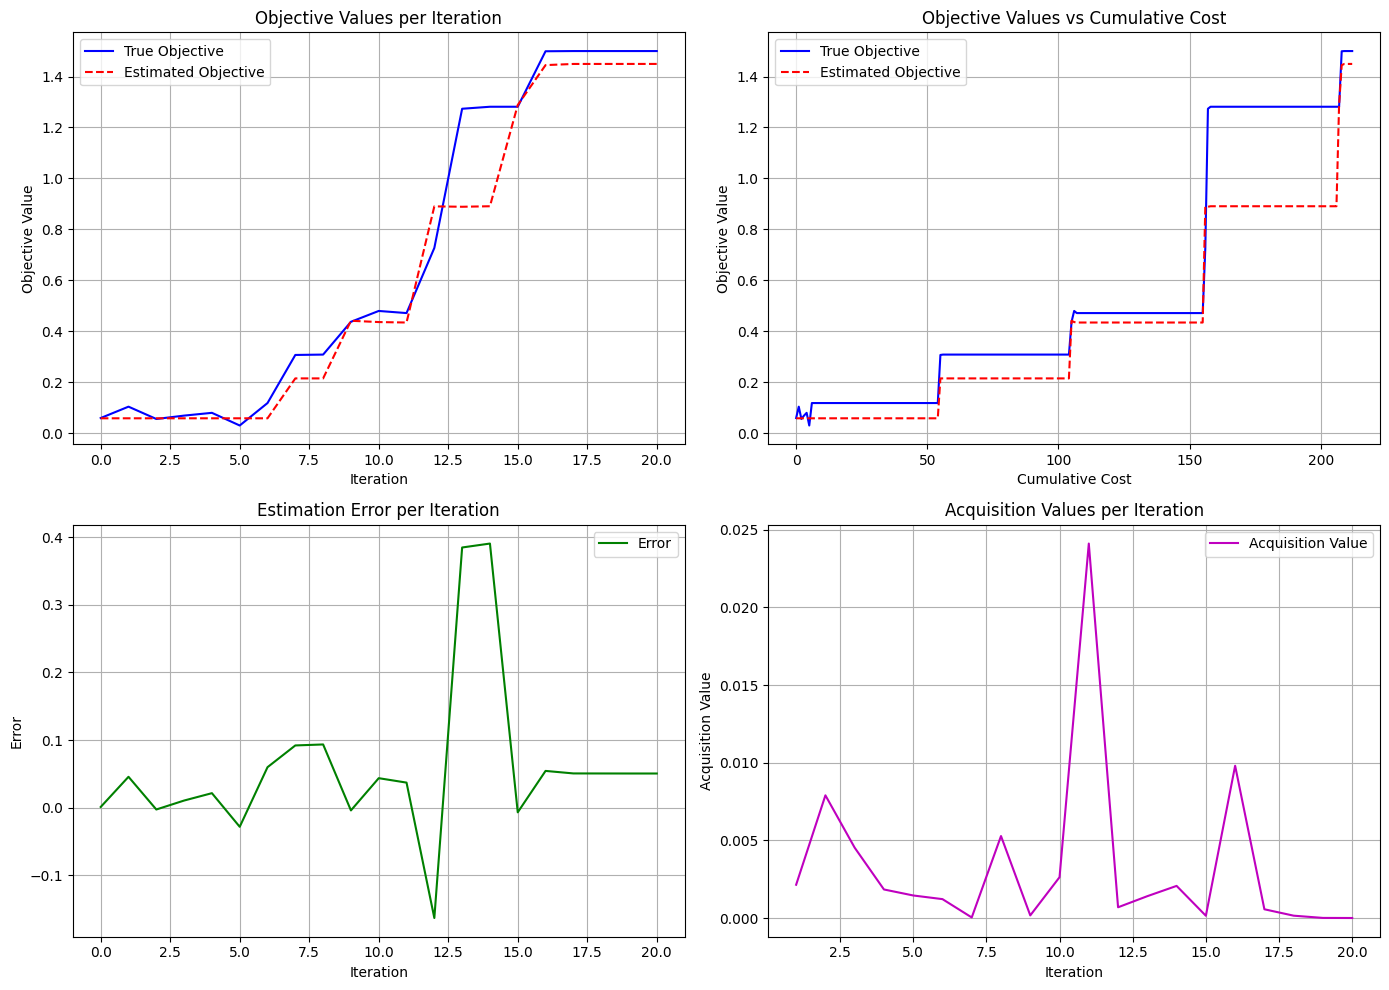

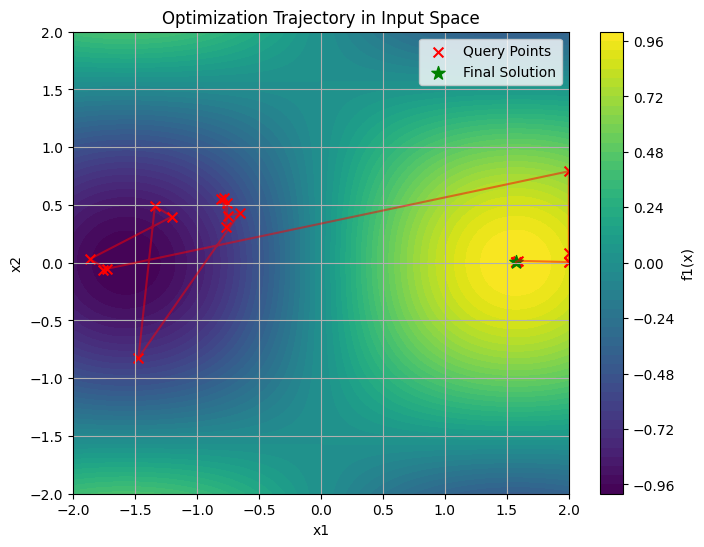

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Objective function value per iteration
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Iteration vs Objective function value
iterations = np.arange(len(results["objective_values"]))
axs[0, 0].plot(iterations, results["objective_values"], 'b-', label='True Objective')
axs[0, 0].plot(iterations, results["estimated_values"], 'r--', label='Estimated Objective')
axs[0, 0].set_title('Objective Values per Iteration')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Objective Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. Objective function value against cost
# Calculate cumulative sum of costs
cumulative_costs = np.cumsum(results["costs"])

# Interpolate to make a monotonic line graph
def step_function_interpolate(x, y):
    x_exp = []
    y_exp = []
    for i in range(len(x) - 1):
        x_exp.append(x[i])
        y_exp.append(y[i])
        x_diff = x[i + 1] - x[i]
        if x_diff > 0:  # Interpolate only if the difference is positive
            for j in range(1, int(x_diff)):
                x_exp.append(x[i] + j)
                y_exp.append(y[i])
    x_exp.append(x[-1])
    y_exp.append(y[-1])
    return np.array(x_exp), np.array(y_exp)

# Interpolation
cum_costs2, obj_vals2 = step_function_interpolate(cumulative_costs, results["objective_values"])
_, est_vals2 = step_function_interpolate(cumulative_costs, results["estimated_values"])

axs[0, 1].plot(cum_costs2, obj_vals2, 'b-', label='True Objective')
axs[0, 1].plot(cum_costs2, est_vals2, 'r--', label='Estimated Objective')
axs[0, 1].set_title('Objective Values vs Cumulative Cost')
axs[0, 1].set_xlabel('Cumulative Cost')
axs[0, 1].set_ylabel('Objective Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. Error between estimated and true values
errors = np.array(results["objective_values"]) - np.array(results["estimated_values"])
axs[1, 0].plot(iterations, errors, 'g-', label='Error')
axs[1, 0].set_title('Estimation Error per Iteration')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Error')
axs[1, 0].legend()
axs[1, 0].grid(True)

# 4. Transition of acquisition function values
acq_vals = np.array(results["acquisition_values"])
valid_indices = ~np.isnan(acq_vals)
if np.any(valid_indices):
    axs[1, 1].plot(iterations[valid_indices], acq_vals[valid_indices], 'm-', label='Acquisition Value')
    axs[1, 1].set_title('Acquisition Values per Iteration')
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('Acquisition Value')
    axs[1, 1].legend()
    axs[1, 1].grid(True)
else:
    axs[1, 1].text(0.5, 0.5, 'No acquisition values available', 
                  horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

# Visualize query points and optimal solution
plt.figure(figsize=(8, 6))
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.flatten(), Y.flatten()))
Z1 = true_f1(torch.tensor(points, dtype=torch.double)).numpy().reshape(X.shape)
temp_inputs = np.array(results["inputs"])

# Display the trajectory of the query points
plt.contourf(X, Y, Z1, 50, cmap='viridis')
plt.colorbar(label='f1(x)')
plt.scatter(temp_inputs[:, 0], temp_inputs[:, 1], color='red', s=50, marker='x', label='Query Points')
plt.plot(temp_inputs[:, 0], temp_inputs[:, 1], 'r-', alpha=0.5)
plt.scatter(temp_inputs[-1, 0], temp_inputs[-1, 1], color='green', s=100, marker='*', label='Final Solution')
plt.title('Optimization Trajectory in Input Space')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()